# Week 4 - Partial Least Squares Regression

We will reimplement and then explore some of the properties of [Cosgrove et al](http://pubs.rsc.org/en/Content/ArticleLanding/2010/MB/b926287c).

In [19]:
import scipy as sp, numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from scipy.io import loadmat
import matplotlib.pyplot as plt

data = sp.io.loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']

X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1)
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins
conditions = data['conditions'].item() # cell array of the 66 conditions
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments
ind4pProtein = data['ind4pProtein'].item() # the column indices corresponding to measurements of the 4 phosphoprotein subset

#### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principal components do you need for each to explain 90% of the Y variance? Discuss your findings.

Hint: Be sure you are normalizing each dataset as needed for the analysis.

In [32]:
phosphoproteins

array(['p-MEK1_0.33hr', 'p-MEK1_4hr', 'p-MEK1_24hr', 'p-MEK1_48hr',
       'p-MEK1_lateAvg', 'p-MEK1_integral', 'p-ERK1/2_0.33hr',
       'p-ERK1/2_4hr', 'p-ERK1/2_24hr', 'p-ERK1/2_48hr',
       'p-ERK1/2_lateAvg', 'p-ERK1/2_integral', 'p-p90RSK_0.33hr',
       'p-p90RSK_4hr', 'p-p90RSK_24hr', 'p-p90RSK_48hr',
       'p-p90RSK_lateAvg', 'p-p90RSK_integral', 'p-CREB_0.33hr',
       'p-CREB_4hr', 'p-CREB_24hr', 'p-CREB_48hr', 'p-CREB_lateAvg',
       'p-CREB_integral', 'p-IRS-1_0.33hr', 'p-IRS-1_4hr', 'p-IRS-1_24hr',
       'p-IRS-1_48hr', 'p-IRS-1_lateAvg', 'p-IRS-1_integral',
       'p-Akt_0.33hr', 'p-Akt_4hr', 'p-Akt_24hr', 'p-Akt_48hr',
       'p-Akt_lateAvg', 'p-Akt_integral', 'p-p70 S6K_0.33hr',
       'p-p70 S6K_4hr', 'p-p70 S6K_24hr', 'p-p70 S6K_48hr',
       'p-p70 S6K_lateAvg', 'p-p70 S6K_integral', 'p-GSK-3a/b_0.33hr',
       'p-GSK-3a/b_4hr', 'p-GSK-3a/b_24hr', 'p-GSK-3a/b_48hr',
       'p-GSK-3a/b_lateAvg', 'p-GSK-3a/b_integral', 'p-STAT3_0.33hr',
       'p-STAT3_4hr', 'p-ST

You need 4 principal components for each to explain the 90% of the Y variance.


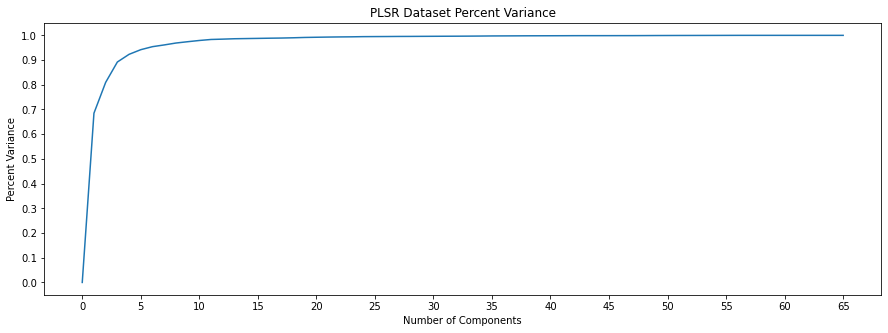

In [21]:
r2y = np.zeros(66)
Y4 = Y[:,4]
pcNum = 0
variance90 = False

for i in range(1,66):
    plsrModel = PLSRegression(n_components=i)
    plsrModel.fit(X,Y4)
    r2y[i] = plsrModel.score(X,Y4)
    if (variance90 == False and r2y[i] >= 0.90):
        pcNum = i
        variance90 = True

print("You need " + str(pcNum) + " principal components for each to explain the 90% of the Y variance.")
plt.figure(figsize=(15,5))
plt.plot(range(0,66), r2y)
plt.xticks(np.arange(0,70,5))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance')
plt.title('PLSR Dataset Percent Variance')
plt.show()

#### (2) How would you expect the percent of X variance explained to compare between PLSR and PCA? Why?

Since PCA maintains maximal variance of X and preserves covariance within a dataset, I expect R2X to be higher in variance for less components. PLSR maximizes covariance and takes into account both X and Y.

#### (3) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList and drugListToxic to identify these categories.

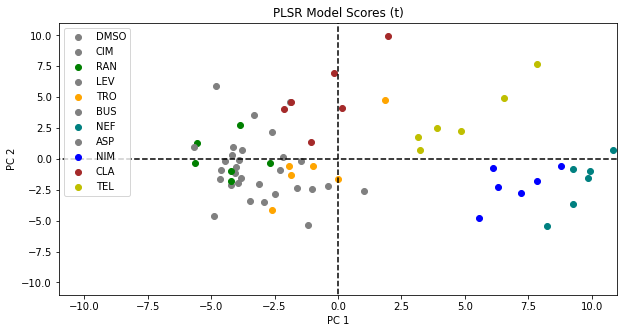

In [22]:
xScores = plsrModel.x_scores_
colors = ['gray', 'gray', 'g', 'gray', 'orange', 'gray', 'teal', 'gray', 'b', 'brown', 'y']
plt.figure(figsize=(10,5))

for i in range(0, 11):
    indices = np.where(drugs[:,i] == 1)
    plt.scatter(xScores[indices, 0], xScores[indices, 1], c = colors[i], label=drugList[i])

plt.plot([0,0], [-100, 100], linestyle='--', color='k')
plt.plot([-100,100], [0,0], linestyle='--', color='k')
plt.xlim(-11,11)
plt.ylim(-11,11)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PLSR Model Scores (t)')
plt.legend()
plt.show()

### (4) Create the loadings plot corresponding to (3). Interpret the results shown on the plot.

In [31]:
print(len(xScores))
xLoad = plsrModel.x_loadings_
print(len(xLoad))

66
102


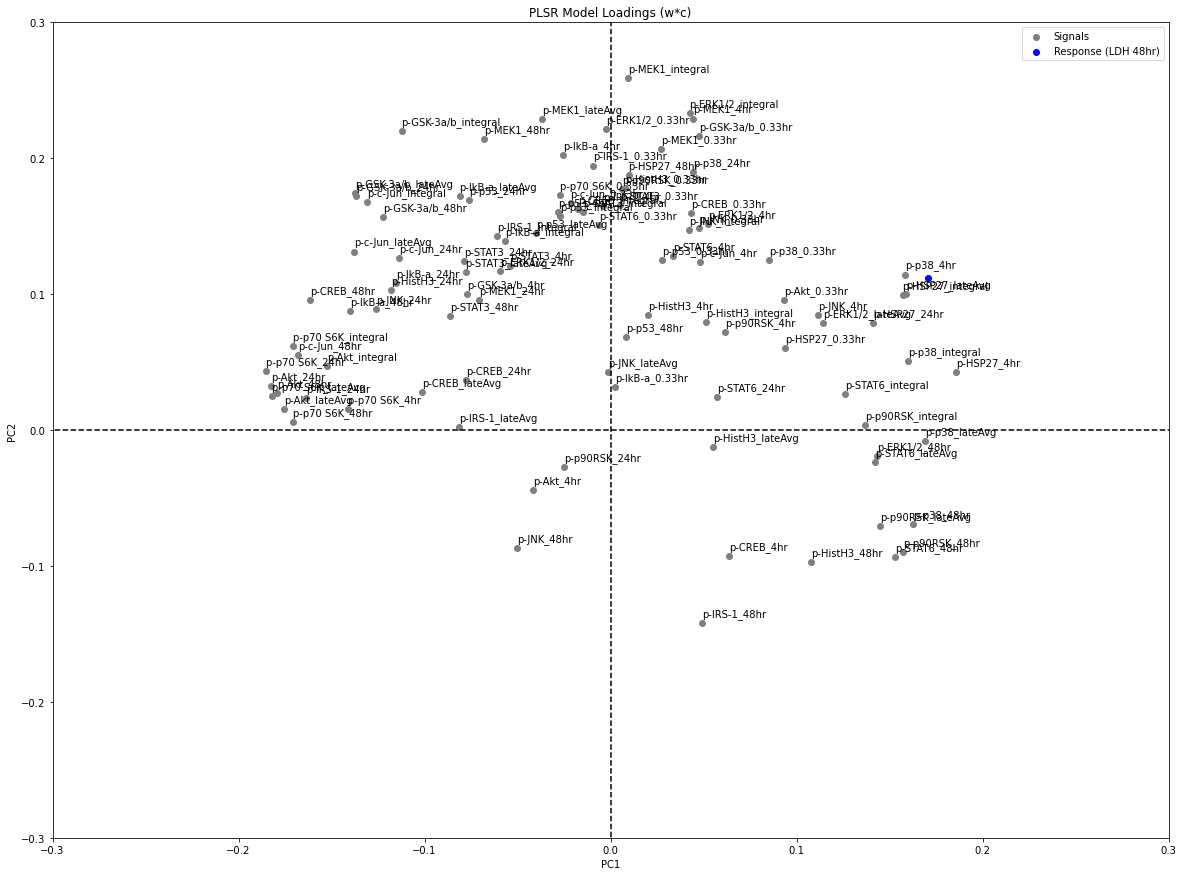

In [24]:
xLoad = plsrModel.x_loadings_
yLoad = plsrModel.y_loadings_

plt.figure(figsize=(20,15))
plt.scatter(xLoad[:,0], xLoad[:,1], c = 'gray')
plt.scatter(yLoad[:,0], yLoad[:,1], c = 'b')

for i in range(xLoad.shape[0]):
        plt.text(xLoad[i,0], xLoad[i,1] + 0.005, phosphoproteins[i], fontsize=10)

plt.legend(['Signals', 'Response (LDH 48hr)'])
plt.plot([0,0], [-100, 100], linestyle='--', color='k')
plt.plot([-100,100], [0,0], linestyle='--', color='k')
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PLSR Model Loadings (w*c)')
plt.show()

This PLSR Model is a loadings plot of X and Y. As seen in the model, the blue dot, or the Y loading, is strongly correlated with positive PC1 and positive PC2. p-p38_4hr is also strongly correlated with positive PC1 and positive PC2 as it is above the Y loading. p-HSP27_4hr has the strongest positive correlation with PC1. p-p70 S6k_24hr has the strongest negative correlation with PC1. p-IRS-1_48hr has the strongest negative correlation with PC2. p-MEK1_integral has the strongest positive correlation with PC2. Thus, the variables that are closest and the furthest to the Y loading are more relevant to predicting LDH release.

#### (5) Add the variance of the loadings to your loadings plot (this can be shown as error bars). How does the variance of component one compare to that of component two? Would you expect a trend in the general variance versus component number?

In [289]:
from sklearn.utils import resample

In [294]:
#bootstrap
xLoadPC1 = np.zeros((102,100))
yLoadPC1 = np.zeros(100)
xLoadPC2 = np.zeros((102, 100))
yLoadPC2 = np.zeros(100)

for i in range(100):
    resamp = resample(range(Y4.shape[0]))
    bootstrapModel = PLSRegression(n_components = 2)
    bootstrapModel.fit(X[resamp], Y4[resamp])
    yLoadPC1[i] = bootstrapModel.y_loadings_[:,0]
    yLoadPC2[i] = bootstrapModel.y_loadings_[:,1]
    for j in range(102):
        xLoadPC1[j,i] = bootstrapModel.x_loadings_[j,0]
        xLoadPC2[j,i] = bootstrapModel.x_loadings_[j,1]
    

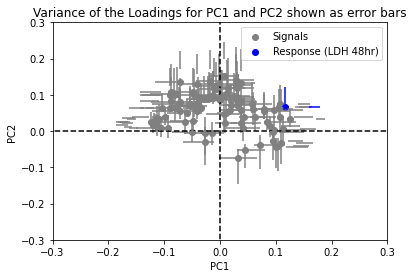

In [295]:
#error
xMeanPC1 = np.zeros(102)
xMeanPC2 = np.zeros(102)
xLowPC1 = np.zeros(102)
xHighPC1 = np.zeros(102)
xLowPC2 = np.zeros(102)
xHighPC2 = np.zeros(102)
yLowPC1 = np.zeros(1)
yHighPC1 = np.zeros(1)
yLowPC2 = np.zeros(1)
yHighPC2 = np.zeros(1)

for i in range (102):
    xMeanPC1[i] = np.mean(xLoadPC1[i])
    xLowPC1[i] = xMeanPC1[i] - np.percentile(xLoadPC1[i], 25)
    xHighPC1[i] = np.percentile(xLoadPC1[i], 75) - xMeanPC1[i]
    xMeanPC2[i] = np.mean(xLoadPC2[i])
    xLowPC2[i] = xMeanPC2[i] - np.percentile(xLoadPC2[i], 25)
    xHighPC2[i] = np.percentile(xLoadPC2[i], 75) - xMeanPC2[i]

yMeanPC1 = np.mean(yLoadPC1)
yMeanPC2 = np.mean(yLoadPC2)
yLowPC1[0] = yMeanPC1 - np.percentile(yLoadPC1, 25)
yHighPC1[0] = np.percentile(yLoadPC1, 75) - yMeanPC1
yLowPC2[0] = yMeanPC2 - np.percentile(yLoadPC2, 25)
yHighPC2[0] = np.percentile(yLoadPC2, 75) - yMeanPC2

plt.scatter(xMeanPC1, xMeanPC2, c='gray')
plt.scatter(yMeanPC1, yMeanPC2, c='blue')
plt.legend(['Signals', 'Response (LDH 48hr)'])
plt.errorbar(xMeanPC1, xMeanPC2, xerr = [xLowPC1, xHighPC1], yerr = [xLowPC2, xHighPC2], c='gray', fmt='*')
plt.errorbar(yMeanPC1, yMeanPC2, xerr = [yLowPC1, yHighPC1], yerr = [yLowPC2, yHighPC2], c='blue', fmt='*')
plt.plot([0,0], [-100, 100], linestyle='--', color='k')
plt.plot([-100,100], [0,0], linestyle='--', color='k')
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Variance of the Loadings for PC1 and PC2 shown as error bars')
plt.show()

Overall, the variance of PC1 seems to be lower than the variance of PC2. The error bars which represent the variance are more noticeable in the PC2 directions. I expect a positive trend in the general variance versus component number since there are more dimensions. In other words, as there are more principal components, the general variance would increase.

#### (6) Recreate a 4-principal component model using PLSR with just the final 4 phosphoprotein model. Plot predicted v. observed LDH for this model. Report the model fitness ($R^2$). Define here how you are calculating $R^2$.

The model fitness is 0.8821898904528919


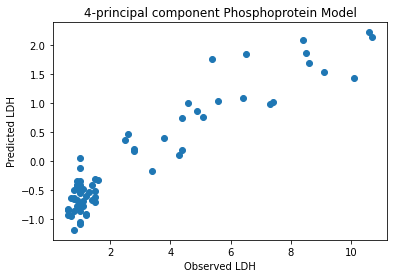

In [296]:
plsr4PModel = PLSRegression(n_components=4)
X4 = sp.stats.zscore(X[:, ind4pProtein])
Y4Z = sp.stats.zscore(Y[:,4])

plsr4PModel.fit(X4,Y4Z)
yPrediction = plsr4PModel.predict(X4)

plt.scatter(Y4, yPrediction)
plt.title("4-principal component Phosphoprotein Model")
plt.xlabel('Observed LDH')
plt.ylabel('Predicted LDH')

R2 = plsr4PModel.score(X4,Y4Z)
print("The model fitness is " + str(R2))

I calculated the coefficient of determination, R^2, by z-scoring X4 and Y4 and then using the PLSR score function.

#### (7) Cosgrove *et al* discusses their method for model validation using leave-one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

The model fitness is 0.8478133855739836


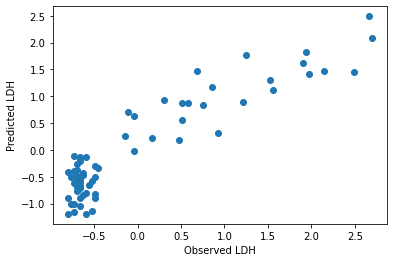

In [298]:
loo = LeaveOneOut()
yLoo = np.zeros(len(Y))

for train_index, test_index in loo.split(yLoo):
    xTrain = X[train_index]
    xTest = X[test_index]
    yTrain = Y4Z[train_index]
    plsrLoo = PLSRegression(n_components=4)
    plsrLoo.fit(xTrain, yTrain)
    yLoo[test_index] = plsrLoo.predict(xTest)

plt.scatter(Y4Z, yLoo)
plt.xlabel('Observed LDH')
plt.ylabel('Predicted LDH')

r2yLoo = 1-(sum((yLoo - Y4Z)**2))/sum(Y4Z**2)
print("The model fitness is " + str(r2yLoo))

It's important to perform cross-validation because it allows us to verify if our model works meaning it can predict new values different from the given data.

#### (8) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

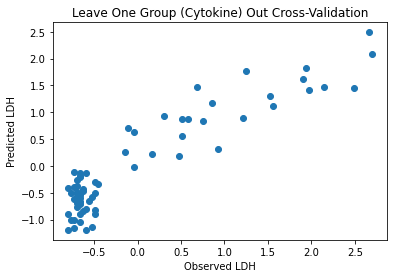

The Q2Y value is 0.8478133855739836


In [299]:
logo = LeaveOneGroupOut()
groups = np.tile(conditions, 1)
yLogo = np.zeros(len(Y))

for train_index, test_index in logo.split(X, Y4Z, groups):
    xTrain = X[train_index]
    xTest = X[test_index]
    yTrain = Y4Z[train_index]
    plsrLogo = PLSRegression(n_components=4)
    plsrLogo.fit(xTrain, yTrain)
    yLogo[test_index] = plsrLogo.predict(xTest)
    
plt.scatter(Y4Z, yLogo)
plt.xlabel("Observed LDH")
plt.ylabel("Predicted LDH")
plt.title("Leave One Group (Cytokine) Out Cross-Validation")
plt.show()

q2yLogo = 1-(sum((yLogo - Y4Z)**2))/sum(Y4Z**2)
print("The Q2Y value is " + str(q2yLogo))

LOGO did not change the Q2Y value of the cross-validation. However, the two approaches differ because in LOO, only one data point at a time is taken whereas LOGO takes a group of data points at a time. Thus, it can be inferred that LOGO accounts for a broader range of values making it less random. Leave One Out would be most appropriate when data points are more random and aren't closely associated as groupings. LOGO is more appropriate when there are known groupings of data points which can be used to compare the model's validity against all of the populations.